# 1. Data cleaning including missing values, outliers and multi-collinearity.

In [1]:
import pandas as pd

In [3]:
dataset = pd.read_csv('Fraud.csv')

In [4]:
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [5]:
dataset.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [6]:
missing_values = dataset.isnull().sum()
print(missing_values)


step              0
type              0
amount            1
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [7]:
# Using IQR method for outlier detection
Q1 = dataset['amount'].quantile(0.25)
Q3 = dataset['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = dataset[(dataset['amount'] < lower_bound) | (dataset['amount'] > upper_bound)]

In [8]:
outliers

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
85,1,TRANSFER,1505626.01,C926859124,0.00,0.00,C665576141,29031.00,5515763.34,0.0,0.0
86,1,TRANSFER,554026.99,C1603696865,0.00,0.00,C766572210,579285.56,0.00,0.0,0.0
88,1,TRANSFER,761507.39,C412788346,0.00,0.00,C1590550415,1280036.23,19169204.93,0.0,0.0
89,1,TRANSFER,1429051.47,C1520267010,0.00,0.00,C1590550415,2041543.62,19169204.93,0.0,0.0
93,1,TRANSFER,583848.46,C1839168128,0.00,0.00,C1286084959,667778.00,2107778.11,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
56116,9,CASH_IN,480796.12,C1723139502,4029573.20,4510369.32,C1231968955,60110.00,696936.92,0.0,0.0
56142,9,TRANSFER,1577749.27,C77325161,880.00,0.00,C882265203,0.00,1705732.61,0.0,0.0
56168,9,TRANSFER,791795.93,C1013293880,189710.00,0.00,C174326515,94418.45,2120505.58,0.0,0.0
56195,9,TRANSFER,1053427.42,C1219628747,200817.08,0.00,C190097337,0.00,1786573.98,0.0,0.0


In [9]:
dataset.shape

(56203, 11)

In [10]:
outliers.shape

(3912, 11)

In [11]:
# Removing outliers
dataset = dataset[(dataset['amount'] >= lower_bound) & (dataset['amount'] <= upper_bound)]


In [12]:
dataset.shape

(52290, 11)

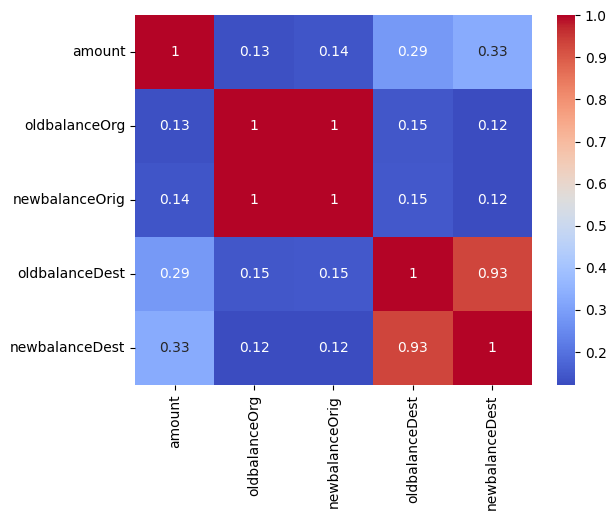

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = dataset[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select the numerical columns
X = dataset[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


          feature         VIF
0          amount    1.444322
1   oldbalanceOrg  894.738175
2  newbalanceOrig  900.406972
3  oldbalanceDest    8.996197
4  newbalanceDest    9.442288


In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataset['nameOrig'] = le.fit_transform(dataset['nameOrig'])
dataset['nameDest'] = le.fit_transform(dataset['nameDest'])


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dataset[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(dataset[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])


# 2. Describe your fraud detection model in elaboration.

To build a fraud detection model, the steps involve selecting the right algorithm, handling imbalanced data, and performing model evaluation. Here's a detailed explanation of the process:

<B>a.) Problem Framing</B>
Binary Classification Problem: The target variable (isFraud) is binary (0 for non-fraudulent, 1 for fraudulent).
Imbalanced Data: Fraudulent transactions are rare compared to non-fraudulent ones, so class imbalance must be handled carefully.

*<b>b.) Data Preprocessing<b>*
Feature Encoding: The type column (categorical feature) should be encoded into numerical values using One-Hot Encoding or Label Encoding.

In [17]:
dataset = pd.get_dummies(dataset, columns=['type'], drop_first=True)


<b>c.) Model Selection</b>

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x = dataset.drop(columns= 'isFraud')

In [20]:
x

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,-0.711393,6110,-0.264386,-0.272299,19637,-0.320728,-0.363319,0.0,False,False,True,False
1,1,-0.780781,17926,-0.331068,-0.334387,20415,-0.320728,-0.363319,0.0,False,False,True,False
2,1,-0.795426,8071,-0.340503,-0.342929,5773,-0.320728,-0.363319,0.0,False,False,False,True
3,1,-0.795426,47931,-0.340503,-0.342929,5134,-0.311066,-0.363319,0.0,True,False,False,False
4,1,-0.695484,28175,-0.321974,-0.329760,10251,-0.320728,-0.363319,0.0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56197,9,1.481042,13396,-0.340567,-0.227544,453,-0.293533,-0.363319,0.0,False,False,False,False
56198,9,-0.657581,2308,-0.142576,-0.155184,334,-0.318074,-0.360154,0.0,True,False,False,False
56199,9,-0.618618,36073,-0.339208,-0.342929,16515,-0.320728,-0.363319,0.0,False,False,True,False
56200,9,0.733030,44050,-0.210630,-0.137590,6150,-0.309742,-0.363319,0.0,False,False,False,False


In [21]:
y = dataset['isFraud']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

<b>d.)  Handling Imbalanced Data<b>

In [24]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

<b>e.) Model Evaluation<b>

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('AUC-ROC:', roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


[[10442     1]
 [   13     2]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10443
         1.0       0.67      0.13      0.22        15

    accuracy                           1.00     10458
   macro avg       0.83      0.57      0.61     10458
weighted avg       1.00      1.00      1.00     10458

AUC-ROC: 0.9307095662166045


<b>f.) Hyperparameter Tuning

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

# 3. How did you select variables to be included in the model?


<b>a.) Domain Knowledge

**Understanding the Dataset**: The features in your dataset represent important transaction information. Here's a breakdown of the columns and their potential significance for fraud detection:

**step**: Represents the time step. It could be useful for
analyzing fraudulent patterns over time(e.g., certain time intervals may see more fraud).

**type**: Transaction type (e.g., PAYMENT, TRANSFER, CASH_OUT). Different types of transactions may have different fraud rates.

**amount**: Transaction amount. Fraudulent transactions often involve unusual amounts (either very high or low).

**nameOrig**: Identifier for the origin account. Although not directly useful for modeling, it can be used to derive features such as the number of transactions per account.

**oldbalanceOrg**: Original balance in the origin account before the transaction. Useful for detecting patterns like high balance accounts being targeted.

**newbalanceOrig**: New balance in the origin account after the transaction. Sudden drops or increases in balance may indicate fraud.

**nameDest**: Identifier for the destination account. Like nameOrig, it may not be directly useful but can help in deriving features (e.g., unusual destinations).

**oldbalanceDest**: Original balance in the destination account. May indicate if the destination is a suspicious account (e.g., balance suddenly goes to zero).

**newbalanceDest**: New balance in the destination account. Similar to oldbalanceDest, this can help detect suspicious behavior.

**isFraud**: Target variable, indicating whether a transaction is fraudulent or not.

**isFlaggedFraud**: Indicates whether the transaction was flagged as fraud by some external system. This can be used to improve accuracy.

**b.) Correlation Analysis**

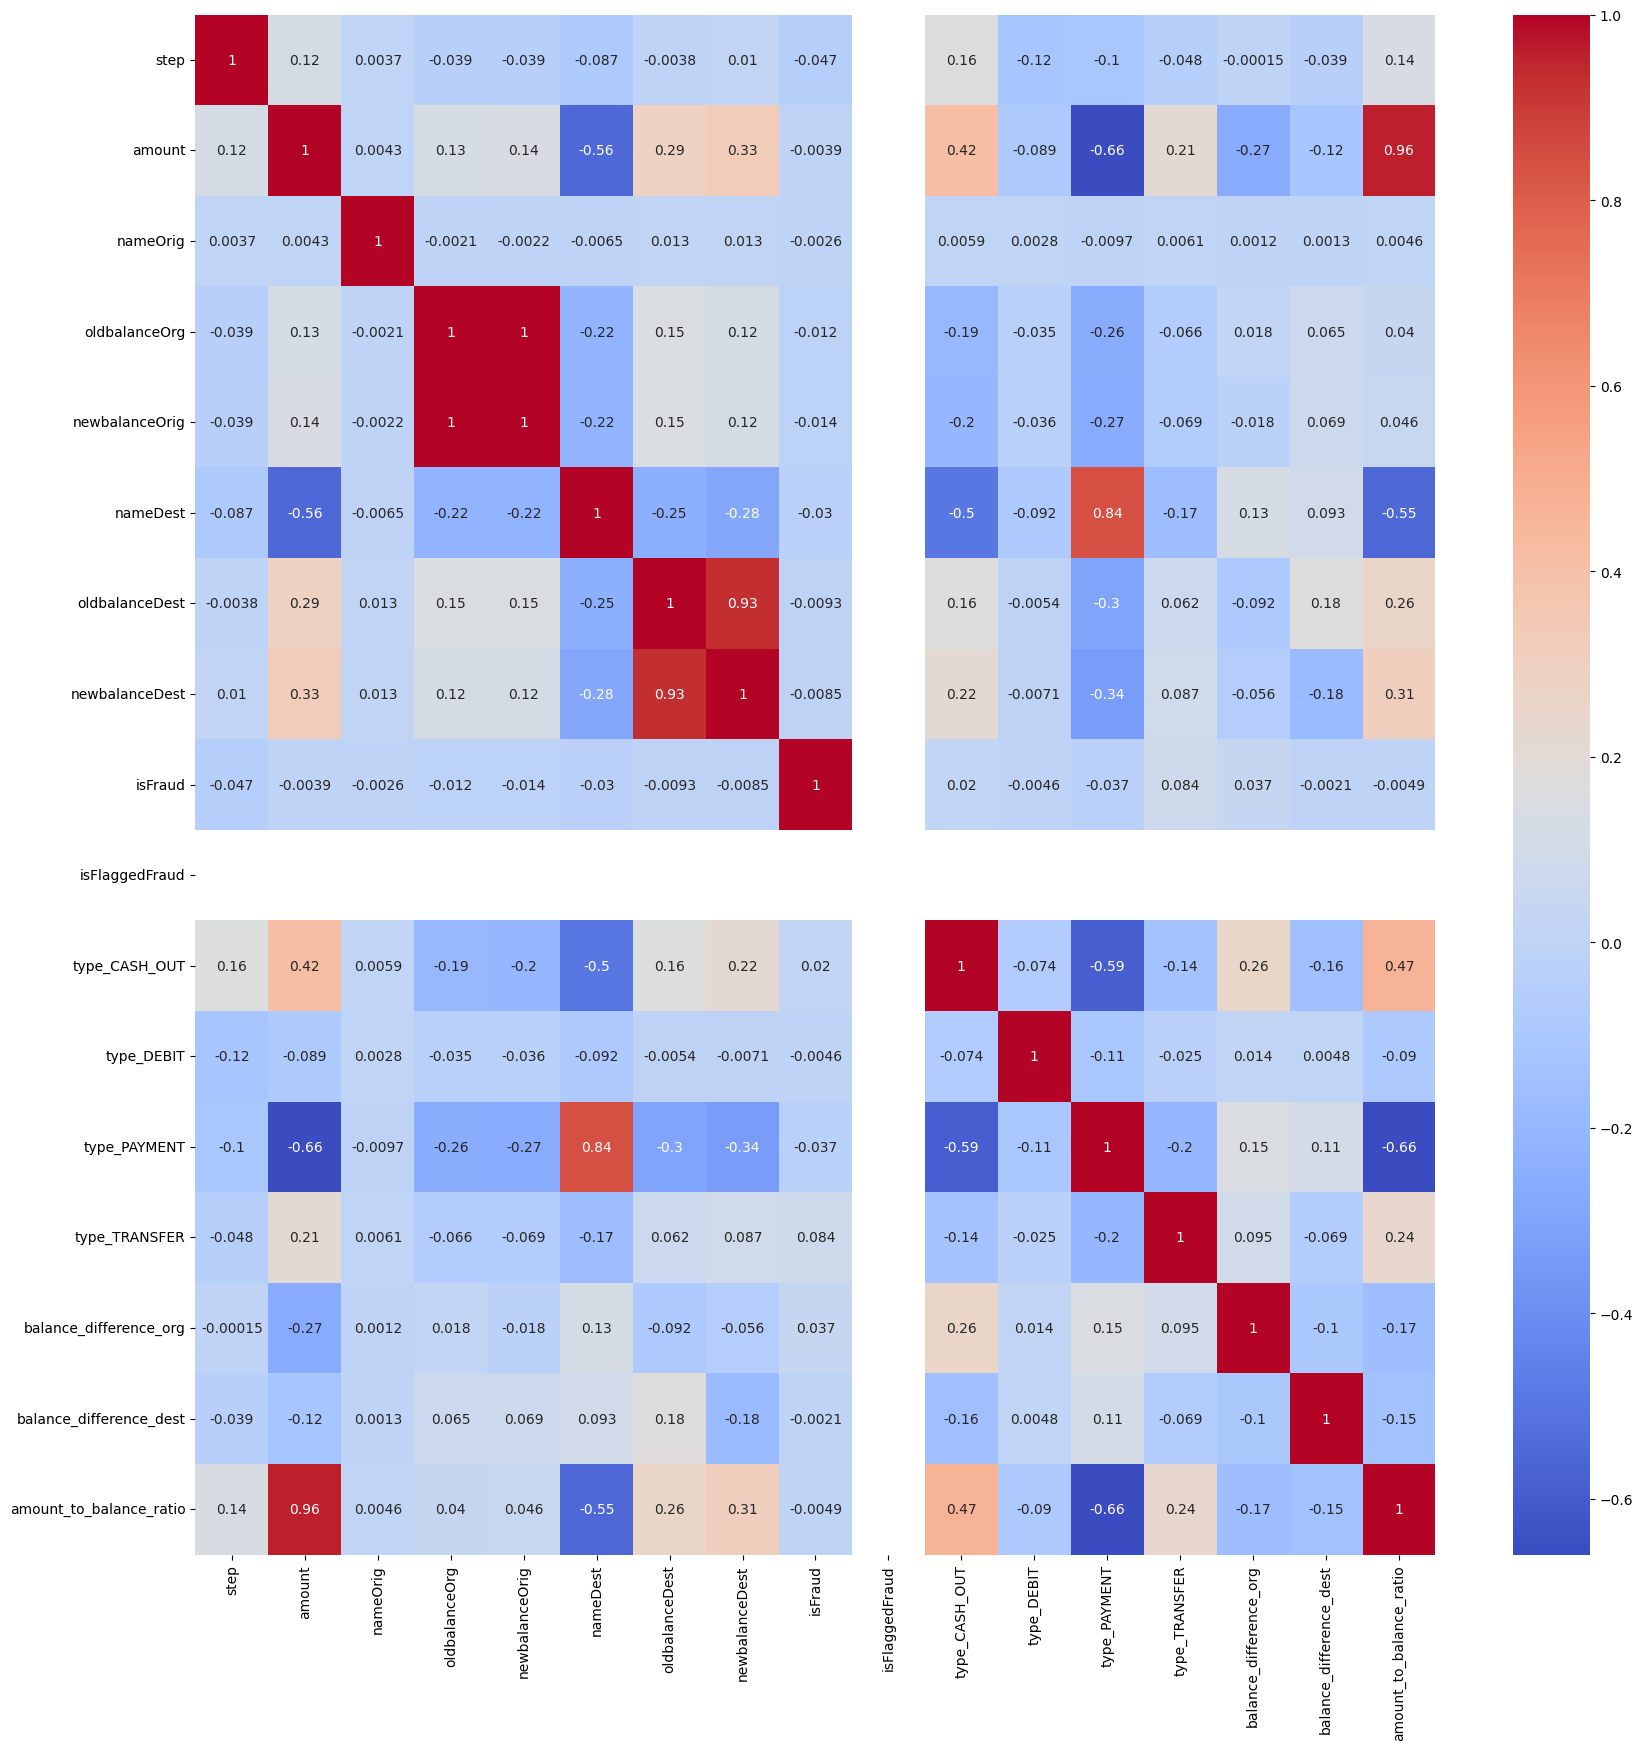

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


**c.) Feature Importance from Models**

In [29]:
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

          Feature  Importance
1   oldbalanceOrg    0.349695
2  newbalanceOrig    0.329613
0          amount    0.154734
3  oldbalanceDest    0.087999
4  newbalanceDest    0.077959


**d.) Feature Engineering**

In [30]:
dataset['balance_difference_org'] = dataset['oldbalanceOrg'] - dataset['newbalanceOrig']
dataset['balance_difference_dest'] = dataset['oldbalanceDest'] - dataset['newbalanceDest']
dataset['amount_to_balance_ratio'] = dataset['amount'] / (dataset['oldbalanceOrg'] + 1) # +1 to avoid division by zero


**f.) Statistical Tests for Feature Selection**

In [36]:
# from sklearn.feature_selection import chi2
# from sklearn.preprocessing import LabelEncoder

# # Convert 'type' to numerical labels
# le = LabelEncoder()
# dataset['type_encoded'] = le.fit_transform(dataset['type'])

# # Apply chi-square test
# chi_scores = chi2(dataset[['type_encoded']], dataset['isFraud'])
# print(chi_scores)


**g.) Avoiding Data Leakage**




*   Avoid using newbalanceOrg or newbalanceDest directly as they may already reflect the outcome of the transaction.
*   Instead, create derived features like balance differences.



# Final Variable Selection Process
**Start with All Transaction-Related Features:** Initial variables include step, type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, and engineered features like balance_difference_org and balance_difference_dest.

**Exclude Identifiers:** Remove nameOrig and nameDest unless they are used for feature engineering.

**Use Feature Importance & Statistical Tests**: Retain only the most relevant features, identified through correlation analysis, feature importance from models, and statistical tests.

**Create New Features:** Engineer new features (e.g., balance differences, amount-to-balance ratio) to capture subtle patterns.

**Ensure No Data Leakage:** Avoid using features that include future information or outcomes of the transaction.


# 4. Demonstrating the Performance of the Fraud Detection Model
To evaluate the model’s performance, we use a range of metrics that are suited for imbalanced datasets, such as fraud detection. Here’s how we can assess the model's performance using the best tools:

a. Train-Test Split
b. Model Training
c. Evaluation Metrics
d. Cross-Validation

In [37]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(f"Average AUC-ROC across 5 folds: {cv_scores.mean()}")


Average AUC-ROC across 5 folds: 0.8554305935030913


[[10442     1]
 [   13     2]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10443
         1.0       0.67      0.13      0.22        15

    accuracy                           1.00     10458
   macro avg       0.83      0.57      0.61     10458
weighted avg       1.00      1.00      1.00     10458

AUC-ROC Score: 0.9307095662166045


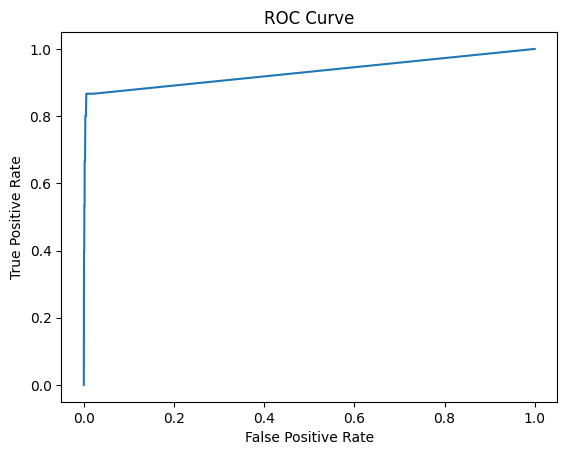

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test)

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# AUC-ROC Score
y_prob = rf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {roc_score}")

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="AUC-ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


# 5. Key Factors that Predict Fraudulent Customers
Key factors that are likely to predict fraudulent transactions (derived from model feature importance and domain knowledge):

**1. Transaction Type (type):** Certain types of transactions, like TRANSFER or CASH_OUT, may be more prone to fraud compared to others like PAYMENT.

**2. Transaction Amount (amount):** Fraudulent transactions often involve unusually high or low amounts.

**3. Original and New Balances (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest):** Large balance differences or suspicious changes in the destination account balance can indicate fraud.

**4. Balance Differences (balance_difference_org, balance_difference_dest):** Sudden drops in the account balance of the origin or destination accounts may flag fraudulent activity.

**5. Amount to Balance Ratio:** Transactions where the amount is disproportionately large compared to the original balance can be indicative of fraud.

# 6. Do These Factors Make Sense?
Yes, these factors make sense for the following reasons:

**1. Transaction Type:** Some transaction types like TRANSFER and CASH_OUT involve direct money movement, making them more vulnerable to fraud than routine payments.

**2. Transaction Amount:** Fraudulent transactions often involve abnormally high amounts as fraudsters try to extract large sums in a short period.

**3. Balance Changes:** Large, unexplained changes in the balance of origin or destination accounts (e.g., a zero balance after a transaction) can be suspicious, as legitimate transactions tend to have more consistent behavior.

**4. Amount to Balance Ratio:** A very high amount compared to the balance is unusual and could signal fraud, especially in a scenario where the entire balance is wiped out.

**5. Balance Differences:** Large changes in balance before and after a transaction can be an indicator that an account has been drained or loaded suspiciously.


# 7. Prevention Measures for Company Infrastructure
To prevent fraud and enhance infrastructure security, the company should adopt several preventive measures:

**1. Anomaly Detection Systems:** Implement real-time fraud detection systems that monitor transactions for unusual patterns and flag them immediately for review.

**2. Transaction Monitoring:** Continuous monitoring of high-risk transactions like large transfers, especially those involving zero-balance accounts.

**3. Limit Transaction Amounts:** Set threshold limits for transactions, especially for new or unverified accounts.

**4. Multi-Factor Authentication (MFA): **Require MFA for high-value transactions or transfers to untrusted destinations.

**5. Behavioral Biometrics:** Use behavioral patterns such as typing speed, device recognition, and geolocation to identify unusual user behavior.

**6. Encryption:** Ensure that transaction data is encrypted both in transit and at rest to protect sensitive information.

**7. Regular Audits:** Conduct regular security audits and vulnerability testing to ensure that the system is resilient to new and evolving threats.

**8. Employee Training:** Train employees to recognize signs of fraud and implement strong internal controls.


# 8. Evaluating the Effectiveness of the Prevention Measures

Once the preventive actions have been implemented, the following steps can be taken to determine if they are working:

**a.) Key Performance Indicators (KPIs)**
Monitor KPIs related to fraud detection and prevention, such as:

**Reduction in Fraud Incidents:** Compare
the number of fraud incidents before and after the implementation of preventive measures.
**False Positives/Negatives:** Track changes in the number of false positives and false negatives to see if the detection system has improved.
**Time to Detect Fraud:** Measure the time taken to detect fraudulent activity and how quickly actions are taken.

**b.) Periodic Testing and Monitoring**

**Penetration Testing:** Conduct regular testing to identify new vulnerabilities and ensure that the infrastructure updates are robust.
**Transaction Monitoring:** Continuously monitor transaction data and evaluate any changes in fraudulent patterns. Real-time dashboards can help track suspicious activities and measure the system’s efficiency.

**c.) Customer Feedback and Reporting**

**User Behavior Analysis:** Track user satisfaction and security-related complaints to detect any unexpected disruptions caused by new security measures.
**Feedback from Security Teams: **Collaborate with internal teams to gather feedback on the effectiveness of fraud detection and prevention mechanisms.

**d.) A/B Testing of Security Enhancements**

Use A/B testing or phased rollouts for new security features to measure how they affect fraud rates. Compare fraud detection rates in the test group with the control group to assess the impact of the new measures.

**e.) Post-Implementation Review**

After a certain period, conduct a review to evaluate the overall success of the implementation:

*   Were fraud rates reduced?
*   Did false positives decrease?
*   Was customer experience impacted positively or negatively?

By combining data-driven metrics with real-time monitoring, you can assess the effectiveness of your fraud prevention strategy and make adjustments as needed.






